In [1]:
# 使用MNIST数据集，MNIST相当于是机器学习界的helloworld
import sklearn 
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_mldata
#mnist=fetch_mldata('mnist-original', data_home='C:/Users/yzy/Desktop/MNIST_DATA')  这个方法暂时拿不到mnist

In [2]:
import tensorflow.examples.tutorials.mnist.input_data as input_data
mnist=input_data.read_data_sets("MNIST")

Extracting MNIST\train-images-idx3-ubyte.gz
Extracting MNIST\train-labels-idx1-ubyte.gz
Extracting MNIST\t10k-images-idx3-ubyte.gz
Extracting MNIST\t10k-labels-idx1-ubyte.gz


In [4]:
trainmnist=mnist.train.images
testmnist=mnist.test.images
trainlabelmnist=mnist.train.labels
testlabelmnist=mnist.test.labels

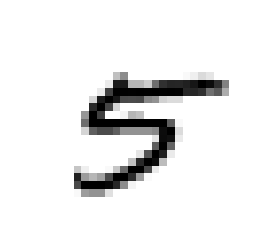

In [4]:
# 画出大概的图像来看一看
import matplotlib.pyplot as plt
import matplotlib
target_image=trainmnist[36000] # 提取某一行
target_image_mm=target_image.reshape(28,28) # 每一个像素点大概是28*28大小
plt.imshow(target_image_mm,cmap='binary',interpolation='nearest')
plt.axis('off')
plt.show()
plt.close()

In [5]:
# 我们先训练一个二分类器
trainlabelmnist_5=(trainlabelmnist==5)
testlabelmnist_5=(testlabelmnist==5)

In [6]:
# 使用随机梯度下降分类方法
from sklearn.linear_model import SGDClassifier # 默认是使用线性支持向量机作为基本的分类器！！
sgdc=SGDClassifier(random_state=42)
sgdc.fit(trainmnist,trainlabelmnist_5)

C:\Users\admin\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=5, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [11]:
from sklearn.model_selection import cross_val_score # 交叉验证查看准确率
score=cross_val_score(sgdc,trainmnist,trainlabelmnist_5,cv=3,scoring='accuracy')

In [12]:
score # 可以看到准确率比较高，但是我们也要想为什么这么高，这时有原因的，因为其实不是5的数据特别多，是5的数据特别少，所以进行2分类的时候
# 只要判断不是5 就能获得很高的accuracy,但是实际上这是很不准确的

array([ 0.96280135,  0.96449026,  0.96689031])

In [13]:
# 另一个交叉验证--自己写函数来验证
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
skfold=StratifiedKFold(n_splits=3,random_state=42) # 将这个随机划分为三份
for trainix,testix in skfold.split(trainmnist,trainlabelmnist_5):
    clonesgdc=clone(sgdc)
    train_fold_train=trainmnist[trainix]
    train_fold_test=trainmnist[testix]
    train_fold_train_label=trainlabelmnist_5[trainix]
    train_fold_test_label=trainlabelmnist_5[testix]
    clonesgdc.fit(train_fold_train,train_fold_train_label)
    predict=clonesgdc.predict(train_fold_test)
    ncorrect=np.sum(predict==train_fold_test_label)
    print(ncorrect/len(predict))

0.962801352678
0.964490263459
0.966890307096


In [14]:
# 构建一个估计器
from sklearn.base import BaseEstimator
class NotFiveAccuracy(BaseEstimator):
    def fit(self,X,y):
        return self
    def predict(self,X):
        return(np.zeros(shape=(len(X),1),dtype=bool))
# 这个是用来将传入的X转化为相同长度的0矩阵，也就是说将这个0矩阵和不是为5的比较以下，看看是不是不是5的居多
from sklearn.model_selection import cross_val_score
notfive=NotFiveAccuracy()
cross_val_score(notfive,trainmnist,trainlabelmnist_5,cv=3,scoring='accuracy')  # 从结果可以看到其实不是5的数据尤其多
# 所以说明上面哪个而分类器事实上并没有那么的准确，只要将所有的结果都表示为False,就能有90%的准确率了，实际上这时很错误的

array([ 0.91087597,  0.90814378,  0.90896198])

In [15]:
from sklearn.model_selection import cross_val_predict
prediction=cross_val_predict(sgdc,trainmnist,trainlabelmnist_5,cv=3) # 返回每一个元素都作为测试集时的训练结果

In [16]:
from sklearn.metrics import confusion_matrix
confusion_matrix(trainlabelmnist_5,prediction)

array([[48993,  1020],
       [  920,  4067]], dtype=int64)

In [17]:
from sklearn.metrics import precision_score,recall_score
precision_score(trainlabelmnist_5,prediction) # 这里判断阴率和阳率是用True和False来判断的是阴还是阳的

0.79948889325732264

In [18]:
recall_score(trainlabelmnist_5,prediction)

0.81552035291758573

In [19]:
from sklearn.metrics import f1_score
f1_score(trainlabelmnist_5,prediction)

0.80742505459598968

In [22]:
 # SGDC本质上是计算出一个决策函数的值，当这个决策函数的值大于某个阈值，分为正类，否则分为负类
pred=sgdc.decision_function([target_image])
# 所以说本质上我们可以不使用fit和predict来预测，fit里面的threshold一般设
#置为0，所以我们可以自己对threshold进行设置
y_target_image_pred=pred>0
y_target_image_pred

array([ True], dtype=bool)

In [21]:
y_target_image_pred=pred>2000 # 当我们把阈值设置为2000时，此时的预测结果便是为false
y_target_image_pred

array([False], dtype=bool)

In [25]:
# 所以到底使用哪个阈值好呢，我们来看一下
from sklearn.model_selection import cross_val_predict
prescore=cross_val_predict(sgdc,trainmnist,trainlabelmnist_5,cv=3,method='decision_function')

In [26]:
from sklearn.metrics import precision_recall_curve
# 这个函数是用于计算在不同的thresholds下不同的precisons，recallls
precisions,recalls,thresholds=precision_recall_curve(trainlabelmnist_5,prescore[:,1])

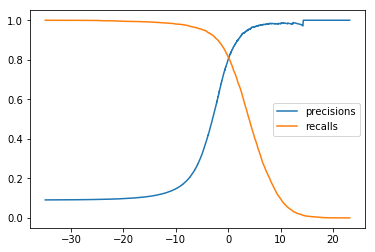

In [27]:
# 第一种选择precisions和recalls的方法--
# 看这样的图片就可以找出合适的threshold来控制precision和recalls
import matplotlib.pyplot as plt
plt.plot(thresholds,precisions[:-1],label='precisions')
plt.plot(thresholds,recalls[:-1],label='recalls')
plt.legend()
plt.show()
plt.close()

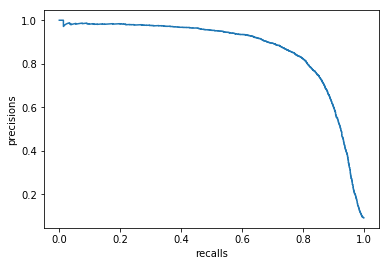

In [28]:
plt.plot(recalls,precisions)
plt.xlabel('recalls')
plt.ylabel('precisions')
plt.show()
plt.close()
# 可以看到precisions在recalls等于0.8左右的时候开始急剧下降，所以需要找一个可能的值
# 把precisions和recalls控制在一个合理的范围内

In [29]:
pred1=sgdc.decision_function(trainmnist)>2

In [30]:
precision_score(y_true=trainlabelmnist_5,y_pred=pred1)

0.89950106913756234

In [31]:
recall_score(y_true=trainlabelmnist_5,y_pred=pred1)

0.75917385201523957

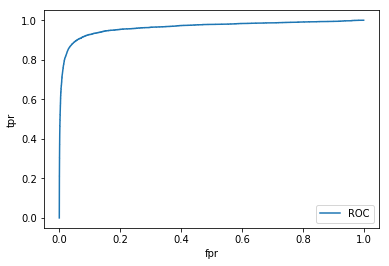

In [32]:
# 绘制ROC曲线
from sklearn.metrics import roc_curve
fpr,tpr,thresholds=roc_curve(trainlabelmnist_5,prescore[:,1])
import matplotlib.pyplot as plt
plt.plot(fpr,tpr,label='ROC')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.legend()
plt.show()
plt.close()

In [33]:
from sklearn.metrics import roc_auc_score
roc_auc_score(trainlabelmnist_5,prescore[:,1])

0.96414969805865314

In [34]:
sgdc.fit(trainmnist,trainlabelmnist)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=5, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [35]:
sgdc.predict([target_image]) # 保持是一个矩阵，而不是一个向量
# 这里是使用的OVA策略，计算出所有的decision_function,选出最大的decision_function

array([5], dtype=uint8)

In [36]:
decision=sgdc.decision_function([target_image]) # 可以看到，训练的10个模型之中，只有5这个模型的decison_function最大

In [37]:
index=np.argmax(decision)
sgdc.classes_[index]

5

In [38]:
# 在处理数据时，也可以自己指定一个算法使用OVO还是使用OVA
from sklearn.multiclass import OneVsOneClassifier
ovo_sgdc=OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_sgdc.fit(trainmnist,trainlabelmnist)
ovo_sgdc.predict([target_image])

C:\Users\admin\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


array([5], dtype=uint8)

In [39]:
# 训练一个多分类算法--RandomForest
from sklearn.ensemble import RandomForestClassifier
rfc=RandomForestClassifier(random_state=42)
rfc.fit(trainmnist,trainlabelmnist)
rfc.predict([target_image])
rfc.predict_proba([target_image])

array([[ 0. ,  0. ,  0. ,  0. ,  0. ,  0.8,  0. ,  0. ,  0. ,  0.2]])

In [36]:
cross_val_score(sgdc, trainmnist, trainlabelmnist, cv=3, scoring="accuracy")

array([ 0.88585919,  0.88741613,  0.86410256])

In [37]:
cross_val_score(rfc, trainmnist, trainlabelmnist, cv=3, scoring="accuracy")

array([ 0.93673992,  0.93732613,  0.94026187])

In [38]:
# scaled 数据可能还能提高准确率
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
x_train_scale=scaler.fit_transform(trainmnist)
cross_val_score(sgdc,x_train_scale,trainlabelmnist,cv=3,scoring='accuracy')

array([ 0.90489175,  0.9071074 ,  0.91216585])

In [40]:
# error analysis
from sklearn.cross_validation import cross_val_predict
y_predict=cross_val_predict(sgdc,trainmnist,trainlabelmnist,cv=3)
from sklearn.metrics import confusion_matrix
matrix1=confusion_matrix(trainlabelmnist,y_predict)

C:\Users\admin\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [41]:
matrix1

array([[5179,    2,   29,   23,   38,   77,   32,   22,   28,   14],
       [   0, 5866,   48,   18,    9,   40,    4,   13,  157,   24],
       [  52,   54, 4709,  148,  114,   43,   59,   89,  174,   28],
       [  49,   22,  114, 4952,   25,  200,   21,   66,  122,   67],
       [  11,   12,   27,    9, 4928,   21,   32,   21,   60,  186],
       [  54,   25,   56,  341,  127, 4005,   61,   44,  193,   81],
       [  38,   30,   63,   18,  172,  148, 4862,   13,   68,    5],
       [  15,   18,   78,   31,   86,   13,    4, 5259,   21,  190],
       [  36,  136,  109,  192,  148,  289,   37,   48, 4247,  147],
       [  32,   12,   29,   97,  460,   61,    0,  347,   71, 4345]], dtype=int64)

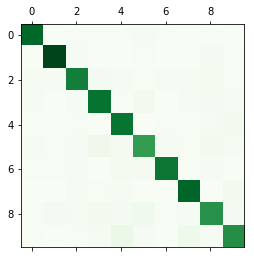

In [42]:
plt.matshow(matrix1,cmap=plt.cm.Greens)
plt.show()
plt.close()

In [44]:
row_sums=matrix1.sum(axis=1)
probmatrix=matrix1/row_sums

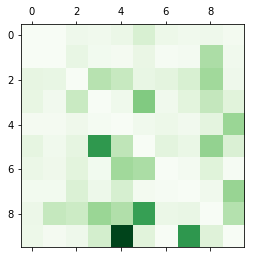

In [45]:
# 讲对角线上面的数据fill为0，这样是为了找出错分比较多的点
np.fill_diagonal(probmatrix,0)
plt.matshow(probmatrix,cmap=plt.cm.Greens)
plt.show()
plt.close()
# 这样就可以发现分类错误比较明显的了

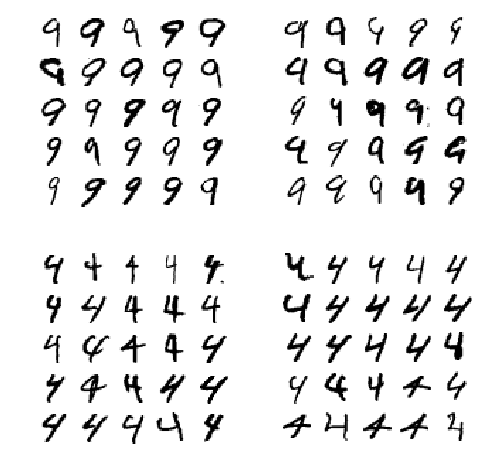

In [49]:
# 观察上图，发现把9错分为4的特别多，所以我们将图片画出来，看看是什么样子
cl_a=9
cl_b=4
X_aa=trainmnist[(trainlabelmnist==cl_a)&(y_predict==cl_a)]
X_ab=trainmnist[(trainlabelmnist==cl_a)&(y_predict==cl_b)]
X_bb=trainmnist[(trainlabelmnist==cl_b)&(y_predict==cl_b)]
X_ba=trainmnist[(trainlabelmnist==cl_b)&(y_predict==cl_a)]
plt.figure(figsize=(8,8))
plt.subplot(221)
plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222)
plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223)
plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224)
plot_digits(X_bb[:25], images_per_row=5)
plt.show()

In [47]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

In [18]:
# multilabel classfication--现在的主要分类器是将单个标签分为一类，但是现在还有一种模式，
# 可能某个特征有多个标签
y_train_large=(trainlabelmnist>=7)
y_train_odd=(trainlabelmnist%2==1)
y_multilable=np.c_[y_train_large,y_train_odd]
y_multilable

array([[ True,  True],
       [False,  True],
       [False, False],
       ..., 
       [False,  True],
       [False, False],
       [ True, False]], dtype=bool)

In [7]:
from sklearn.neighbors import KNeighborsClassifier
knn_c=KNeighborsClassifier()
knn_c.fit(trainmnist,y_multilable)

NameError: name 'y_multilable' is not defined

In [52]:
knn_c.predict([target_image])

array([[False,  True]], dtype=bool)

In [53]:
knn_c.fit(trainmnist,trainlabelmnist)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [ ]:
# 评价好坏的标准，F1score
y_train_knn_pred=cross_val_predict(knn_c,trainmnist,trainlabelmnist,cv=3)

In [ ]:
f1_score(trainlabelmnist,y_train_knn_pred,average='macro')

In [57]:
y_train_knn_pred

NameError: name 'y_train_knn_pred' is not defined

In [5]:
# mutioutput classification
noise1=np.random.randint(0,100,(len(trainmnist),784))
noise2=np.random.randint(0,100,(len(testmnist),784))
X_train_mod = trainmnist + noise1
X_test_mod = testmnist + noise2
y_train_mod = trainmnist
y_test_mod = testmnist

In [20]:
import matplotlib
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = matplotlib.cm.binary,
               interpolation="nearest")
    plt.axis("off")

C:\Users\admin\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


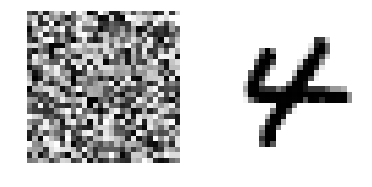

In [22]:
import matplotlib.pyplot as plt
some_index = 5500
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
plt.show()

In [24]:
knn_c.fit(X_train_mod, y_train_mod)

ValueError: Unknown label type: 'continuous-multioutput'

In [ ]:
clean_digit = knn_c.predict([X_test_mod[some_index]])